In [1]:
# IMPORT MODULES

import numpy as np
from numpy import ma
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from matplotlib import ticker, cm
from matplotlib.pyplot import figure
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, decomposition, preprocessing

from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

Using TensorFlow backend.


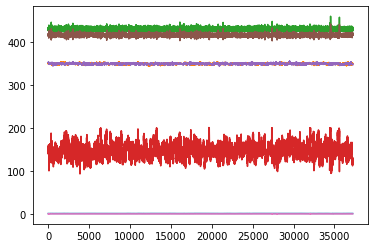

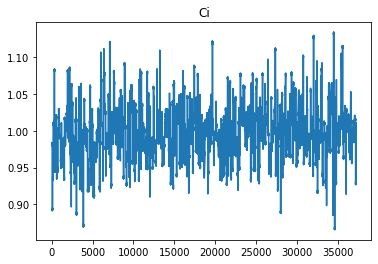

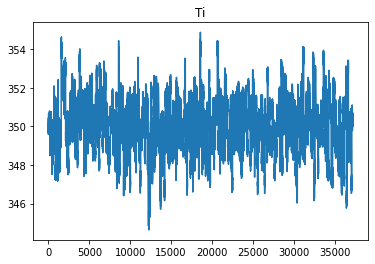

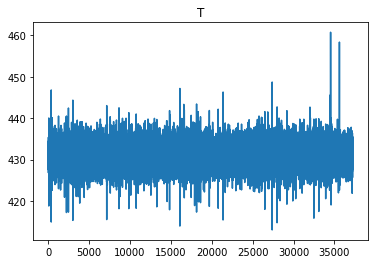

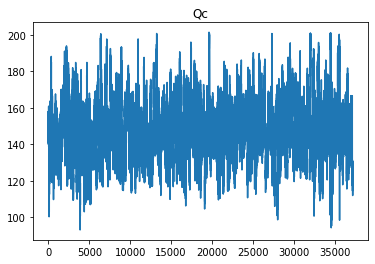

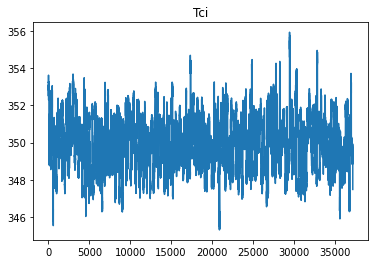

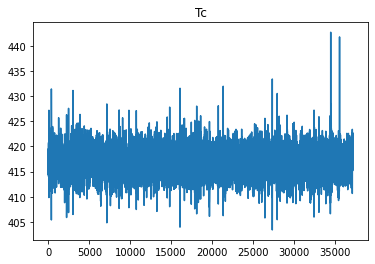

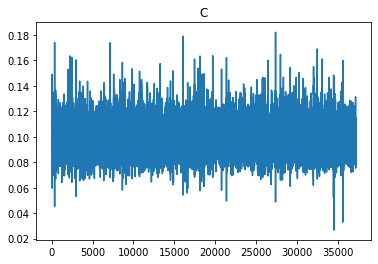

In [26]:
dfRaw = pd.read_excel('Model data.xlsx',engine='openpyxl')
df=dfRaw
# print(dfRaw.shape)
# print(dfRaw.columns)

d=dfRaw.iloc[:,2:9]
plt.plot(d)
plt.show()
name=['Ci', 'Ti', 'T', 'Qc', 'Tci', 'Tc', 'C']

for i in range(7):
    plt.plot(d.iloc[:,i])
    plt.title(name[i], fontdict=None, loc='center', pad=None)
    plt.show()

In [28]:
data = dfRaw.copy()
normal_data = data.loc[data["Class"] == 0]
fault_data = data.loc[data["Class"] == 1]

print("data ", data.shape)
print("normal_data ", normal_data.shape)
print("fault data ", fault_data.shape)
print("Percent fault ", round((len(fault_data)/len(data)), 4),"%")


data  (37229, 9)
normal_data  (37229, 9)
fault data  (0, 9)
Percent fault  0.0 %


/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


------------------------------------------------------------------------
Training for fold 0 ...


TypeError: 'Text' object is not callable

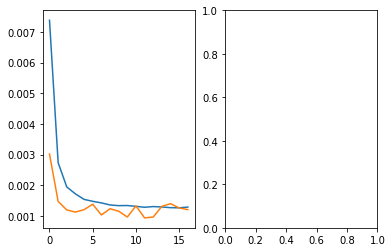

In [33]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


from sklearn.model_selection import train_test_split
import sklearn
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import decomposition
import scipy


from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, decomposition, preprocessing
from sklearn.model_selection import KFold


df = pd.read_excel('Model data.xlsx',engine='openpyxl')
# all features
x = df[df.columns[2:9]].to_numpy()

# column with class
y = df[df.columns[1]].to_numpy()


# This portion of code remove anomalies if the dataset contained anomalies

df = pd.concat([pd.DataFrame(x), pd.DataFrame({'anomaly': y})], axis=1)
normal_events = df[df['anomaly'] == 0]


normal_events = normal_events.loc[:, normal_events.columns != 'anomaly']




# # scaling
scaler = preprocessing.MinMaxScaler()

scaler.fit(df.drop('anomaly', 1))

scaled_data = scaler.transform(normal_events)

# # 80% percent of dataset is designated to training
train_data, test_data = train_test_split(scaled_data, test_size=0.1)
n_features = x.shape[1]

inputs = np.concatenate((train_data, test_data), axis=0)


# Define the K-fold Cross Validator
num_folds=5
kfold = KFold(n_splits=num_folds, shuffle=True)

acc=[]
val_acc=[]
prediction_loss_error=[]

i=0

for train, test in kfold.split(inputs):
    
    # # model
    encoder = keras.Sequential(name='encoder')
    encoder.add(layer=keras.layers.Dense(units=20, activation=keras.activations.relu, input_shape=[n_features]))
    encoder.add(keras.layers.Dropout(0.1))
    encoder.add(layer=keras.layers.Dense(units=10, activation=keras.activations.relu))
    encoder.add(layer=keras.layers.Dense(units=5, activation=keras.activations.relu))

    decoder = keras.Sequential(name='decoder')
    decoder.add(layer=keras.layers.Dense(units=10, activation=keras.activations.relu, input_shape=[5]))
    decoder.add(layer=keras.layers.Dense(units=20, activation=keras.activations.relu))
    decoder.add(keras.layers.Dropout(0.1))
    decoder.add(layer=keras.layers.Dense(units=n_features, activation=keras.activations.sigmoid))

    autoencoder = keras.Sequential([encoder, decoder])

    autoencoder.compile(
        loss=keras.losses.MSE,
        optimizer=keras.optimizers.Adam(),
        metrics=[keras.metrics.mean_squared_error,'accuracy'])
    

    # train model
    es = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5, restore_best_weights=True)
#     history = autoencoder.fit(x=train_data, y=train_data, epochs=100, verbose=1, validation_data=[test_data, test_data], callbacks=[es])
    
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {i} ...')

    # Fit data to model
    history = autoencoder.fit(x=inputs[train], y=inputs[train], epochs=50, verbose=0, validation_data=[test_data, test_data], callbacks=[es])
    
    
    # Mean Squared error
    train_predicted_x = autoencoder.predict(x=inputs[train])
    train_events_mse=sklearn.metrics.mean_squared_error(inputs[train], train_predicted_x)

    prediction_loss_error.append(train_events_mse)
    acc.append(history.history['accuracy'])
    val_acc.append(history.history['val_accuracy'])
    
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('Model Loss')
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Test'], loc='upper left')
#     plt.show()
    
    
#     plt.plot(history.history['accuracy'])
#     plt.plot(history.history['val_accuracy'])
#     plt.title('model accuracy')
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'test'], loc='upper left')
#     plt.show()
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.title('Model Loss')
    ax1.ylabel('Loss')
    ax1.xlabel('Epoch')
    ax1.legend(['Train', 'Test'], loc='upper left')
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.title('model accuracy')
    ax2.ylabel('accuracy')
    ax2.xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper left')
    plt.show()

    i=i+1


# Increase fold number
i = i + 1

print(f'> Loss: {np.mean(prediction_loss_error)}')
print(f'> acc: {np.mean(acc)}')
print(f'> val_acc: {np.mean(val_acc)}')

/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


MSE
0.006385306944139302
0.0019685077


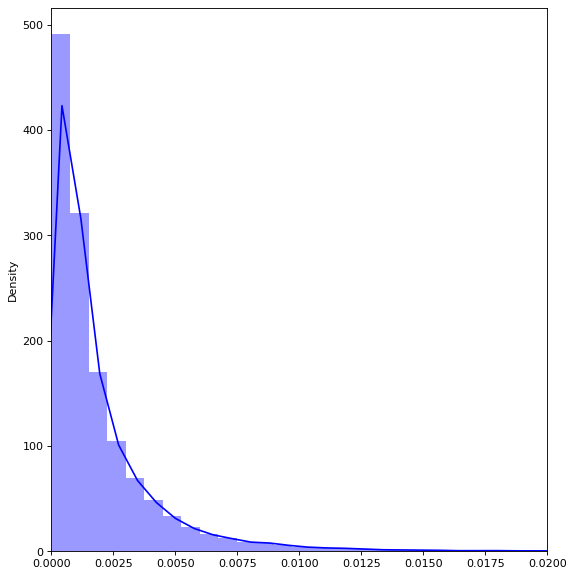

In [19]:

# Mean Squared error
train_predicted_x = autoencoder.predict(x=train_data)
train_events_mse = keras.losses.mean_squared_error(train_data, train_predicted_x)
cut_off = np.percentile(train_events_mse, 95)

# loss distribution

plt.figure(figsize=(8,9), dpi=80)
sns.distplot(train_events_mse, bins=200, kde=True, color='blue')
plt.xlim([0., .02]);


print('MSE')
print(cut_off)
print(np.average(train_events_mse.numpy()))



# # Mean Absolute error
# train_predicted_x = autoencoder.predict(x=train_data)
# train_events_mae = keras.losses.mean_absolute_percentage_error(train_data, train_predicted_x)
# cut_off = np.percentile(train_events_mae, 95)


# # loss distribution

# plt.figure(figsize=(8,9), dpi=80)
# sns.distplot(train_events_mae, bins=2000, kde=True, color='blue')
# plt.xlim([0., 50000]);


# print('')
# print('MAE')
# print(cut_off)
# print(np.average(train_events_mae.numpy()))


# # Mean Log error
# train_predicted_x = autoencoder.predict(x=train_data)
# train_events_mle = keras.losses.mean_squared_logarithmic_error(train_data, train_predicted_x)
# cut_off = np.percentile(train_events_mle, 95)

# # loss distribution

# plt.figure(figsize=(8,9), dpi=80)
# sns.distplot(train_events_mle, bins=200, kde=True, color='blue')
# plt.xlim([0., .02]);

# print('')
# print('MLE')
# print(cut_off)
# print(np.average(train_events_mle.numpy()))



         Var2_ 2     Var2_ 3   Var2_ 4     Var2_ 5   Var2_ 6     Var2_ 7  \
0     349.200674  349.306994  1.052794  349.311503  0.101061  430.909217   
1     349.200674  349.306994  1.053481  349.343435  0.088325  434.649320   
2     349.200674  349.306994  1.051711  349.521754  0.115331  428.269601   
3     349.200674  349.306994  1.053325  349.296442  0.099334  432.723509   
4     349.200674  349.306994  1.054287  349.272830  0.110713  428.600419   
...          ...         ...       ...         ...       ...         ...   
1196  349.056198  350.305100  1.057063  398.506434  0.107946  430.249968   
1197  349.056198  350.305100  1.056160  398.776439  0.106117  431.056109   
1198  349.056198  350.305100  1.057351  398.842077  0.112583  429.227286   
1199  349.056198  350.305100  1.057955  398.767036  0.090557  434.564239   
1200  350.130566  352.392970  1.053720  400.329672  0.123396  426.921257   

         Var2_ 8  
0     148.197260  
1     165.141361  
2     159.078867  
3     160.5

/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


''

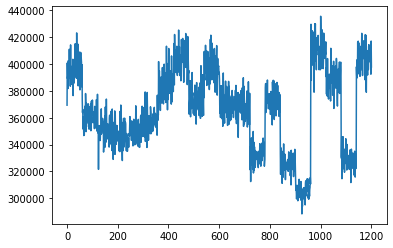

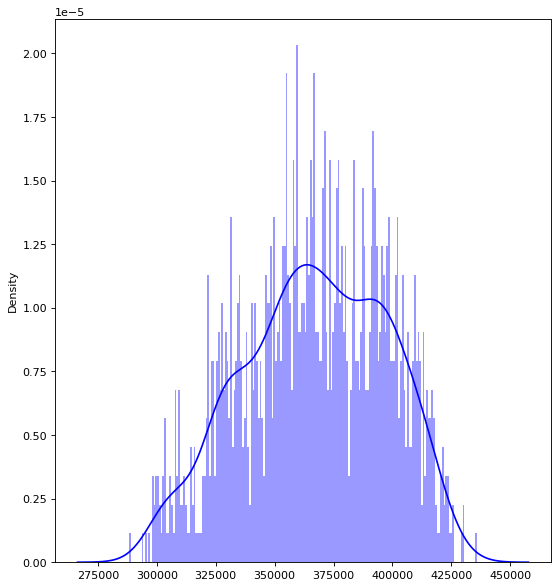

In [33]:
# Import dataset whihc has a fault to be detected

df = pd.read_excel('Fault 110.xlsx',engine='openpyxl')
# df=df.iloc[:,2:8]
# plt.plot(df)




plot_samples=1201
# all features
x = df[df.columns[2:9]].to_numpy()
print(df[df.columns[2:9]])
print(x.shape[1])
# column with class
y = df[df.columns[1]].to_numpy()



# Creating a data frame and calling the class "Anomaly"
abnormal_events = pd.concat([pd.DataFrame(x), pd.DataFrame({'anomaly': y})], axis=1)
abnormal_events = abnormal_events.loc[:, abnormal_events.columns != 'anomaly']

# abnormal event
abnormal_x = scaler.transform(abnormal_events).reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(abnormal_x)
abnormal_events_mse = keras.losses.mean_squared_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
    
	'n': np.arange(0, plot_samples),    
	'mse': abnormal_events_mse})


Final=pd.DataFrame(abnormal_events_df.mse)

Final['cutoff']=0.001

print(Final)
plt.plot(abnormal_events_df.mse)


# abnormal_events_df.to_excel('test4.xlsx')


plt.figure(figsize=(8,9), dpi=80)
sns.distplot(abnormal_events_mse, bins=200, kde=True, color='blue')
;

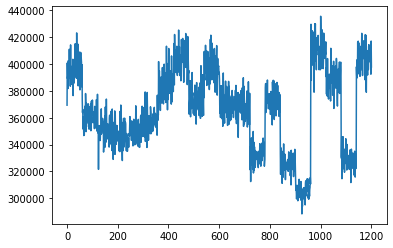

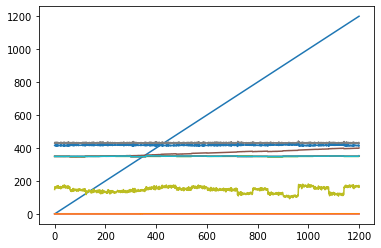

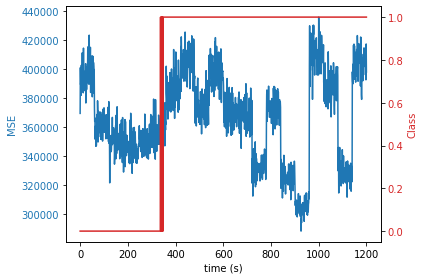

In [34]:
import numpy as np
import matplotlib.pyplot as plt



plt.plot(abnormal_events_df.mse)
plt.show()
df = pd.read_excel('Fault 110.xlsx',engine='openpyxl')
plt.plot(df)
plt.show()


df=df.Class
data1 = abnormal_events_mse
data2 = df

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('MSE', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Class', color=color)  # we already handled the x-label with ax1
ax2.plot(data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()